<a href="https://colab.research.google.com/github/zigg17/pytorchPractice/blob/main/02_pytorch_nn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classifications with NN**


---



To start we'll begin working with sklearn. Colab has the sklearn already downloaded making this a simple process.

In [1]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 points
n_samples = 1000

# Create circles
x, y = make_circles (n_samples,
                     noise=0.03,
                     random_state=42)

print(f"x length: {len(x)} | y length: {len(y)}")

print(f"First 5 of x: \n{x[:5]}\n")
print(f"First 5 of y: \n{y[:5]}")

x length: 1000 | y length: 1000
First 5 of x: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 of y: 
[1 1 1 1 0]


For y, it shows that the two options are 1 and 0, making a binary classification. For the next step, were going to enter everything into a dictionary.

In [2]:
import pandas as pd
circles = pd.DataFrame({"X1": x[:, 0],
                        "X2": x[:, 1],
                        "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


It's somewhat hard to determine any pattern in this dataset. We can help look for patterns via matplotlib

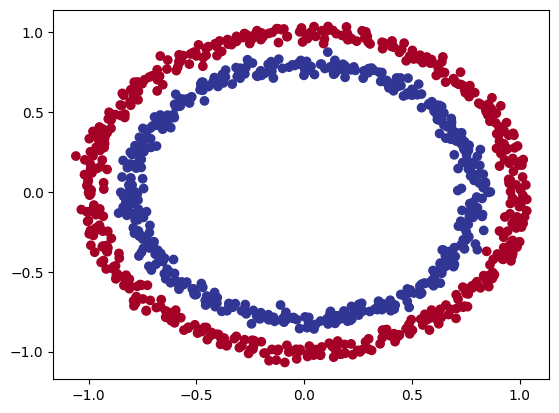

In [3]:
import matplotlib.pyplot as plt
plt.scatter (x = x[:, 0],
              y = x[:, 1],
              c = y,
              cmap = plt.cm.RdYlBu);

As we can see here, we have a set of coordinates and then a binary distinction of whether or not this point is within the blue circle or the red one.

At the beginning we will be converting from numpy to a torch tensor. This will allow us to use the data in all torch related activities.

In [4]:
import torch
from torch import nn

# Incorporation of device agnostic code for optomization no matter where code is ran
device = "cuda" if torch.cuda.is_available() else "cpu"

# Conversion to torch float, we will be changing it from numpy.float64 to torch.float32
# Its good practice to convert to float32 as there may be some errors that arise from
# lack of use.
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x,y,
                                                    test_size = .2,
                                                    random_state = 42)

class circleID (nn.Module):
  def __init__(self):
    super().__init__()
    self.doubleLayer = nn.Sequential(
        nn.Linear(in_features = 2, out_features = 50),
        nn.ReLU(),
        nn.Linear(in_features = 50, out_features = 50),
        nn.ReLU(),
        nn.Linear(in_features = 50, out_features = 100),
        nn.ReLU(),
        nn.Linear(in_features = 100, out_features = 50),
        nn.ReLU(),
        nn.Linear(in_features = 50, out_features = 1),
        )

  def forward(self, x):
    return self.doubleLayer(x)

circleModel = circleID().to(device)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = circleModel.parameters(), lr = .1)

def accuracy_fn(y_true, y_pred):
  correct = torch.eg(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

basic stuff to evaluate the logits, which will then be transformed into probabilities later. Remember logits are not probabilities and must undergo a process in order to become probabilities. In our circimstance, we are going to put them through a sigmoid function to create probabilities.

In [6]:
circleModel.eval()
with torch.inference_mode():
  Y_logits = circleModel(X_test.to(device))
Y_logits[:10]

tensor([[0.0225],
        [0.0314],
        [0.0322],
        [0.0259],
        [0.0241],
        [0.0229],
        [0.0416],
        [0.0360],
        [0.0323],
        [0.0324]])

Undergoing the sigmoid function to transform logits into probabilities.

In [7]:
y_pred_probs = torch.sigmoid(Y_logits)
y_pred_probs[:10]

tensor([[0.5056],
        [0.5078],
        [0.5081],
        [0.5065],
        [0.5060],
        [0.5057],
        [0.5104],
        [0.5090],
        [0.5081],
        [0.5081]])

Rounding the probabilities to transform predictions into binary categories.

In [8]:
y_preds = torch.round(y_pred_probs)
y_preds[:10]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

Now, just applying that all to one line of code.

In [9]:
y_preds = torch.round(torch.sigmoid(circleModel(X_test.to(device))))
y_preds[:10]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SliceBackward0>)

Now with all of this practiced it's time to integrate into one training loop!!

Training loop:
1. Forward pass
2. Loss calculation
3. optomizer zero grad
4. Loss backward (backpropogation)
5. Optimizer(gradient descent)

In [10]:
# Establishing lists
epochCount = []
trainLosses = []
testLosses = []

# Establishing iteration count
epochs = 10000

# Moving everything to GPU (device agnostic)
X_train, X_test = X_train.to(device), X_test.to(device)
Y_train, Y_test = Y_train.to(device), Y_test.to(device)

# Training loop
for epoch in range(epochs):
  # Set to training
  circleModel.train()

  # train then model and capture predictions
  yTrainLogits = circleModel(X_train).squeeze()
  yTrainPred = torch.round(torch.sigmoid(yTrainLogits))

  # Juxtapose in a loss_fn
  trainLoss = loss_fn(yTrainLogits, Y_train)

  # Do optimizer stuff and things, LEARN THIS ASAP
  optimizer.zero_grad()

  # Backpropogation for loss function
  trainLoss.backward()

  # Step the optimizer
  optimizer.step()

  circleModel.eval()
  with torch.inference_mode():
    # Forward
    yTestLogits = circleModel(X_test).squeeze()
    yTestPred = torch.round(torch.sigmoid(yTestLogits))

    # Juxtapose in loss
    testLoss = loss_fn(yTestLogits, Y_test)

  if epoch % 1000 == 0:
    # Print available data
    print(f"Epoch: {epoch} | Train loss: {trainLoss:.3f} | Test loss: {testLoss:.3f}")
  epochCount, trainLosses, testLosses = epochCount + [epoch], trainLosses + [trainLoss], testLosses + [testLoss]


Epoch: 0 | Train loss: 0.694 | Test loss: 0.693
Epoch: 1000 | Train loss: 0.012 | Test loss: 0.025
Epoch: 2000 | Train loss: 0.001 | Test loss: 0.005
Epoch: 3000 | Train loss: 0.000 | Test loss: 0.003
Epoch: 4000 | Train loss: 0.000 | Test loss: 0.003
Epoch: 5000 | Train loss: 0.000 | Test loss: 0.002
Epoch: 6000 | Train loss: 0.000 | Test loss: 0.002
Epoch: 7000 | Train loss: 0.000 | Test loss: 0.002
Epoch: 8000 | Train loss: 0.000 | Test loss: 0.002
Epoch: 9000 | Train loss: 0.000 | Test loss: 0.001


Now, we're running into issues where we our model is essentially randomly predicting with no real direction. To mitigate this issue and begin to visualize where the problems might be occuring we're going to import helper functions. To do this we'll be using `import requests` and the `pathlib`.

In [11]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, download skipped")
else:
  print("helper_functions.py DNE, download initiated")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py DNE, download initiated


After using the requests library to pull in information of out a git link, it's time to work on data visualization.

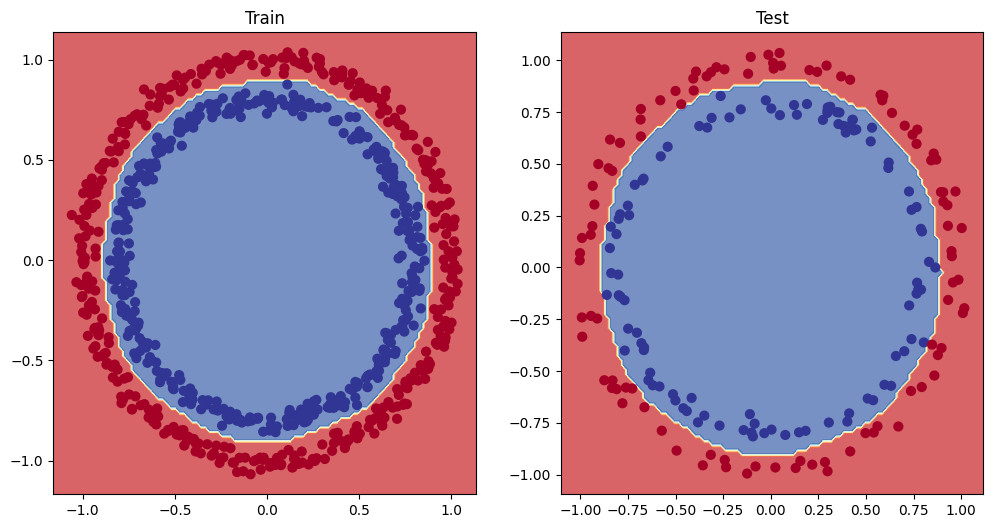

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot (1, 2, 1)
plt.title("Train")
plot_decision_boundary (circleModel, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title( "Test")
plot_decision_boundary(circleModel, X_test, Y_test)

# **More Practice**


---



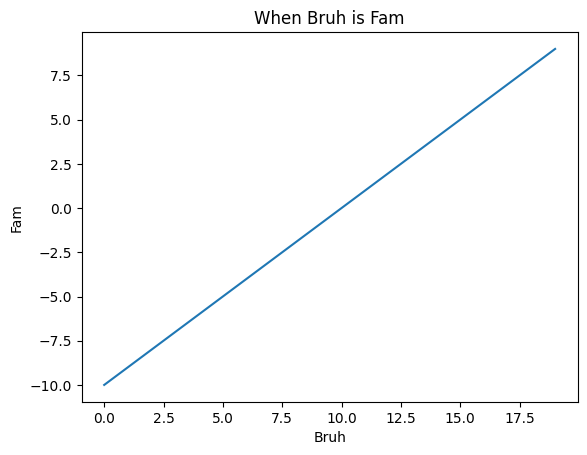

In [13]:
tensee = torch.arange(start = -10, end = 10,
                      step = 1, dtype = torch.float32)

plt.plot(tensee)
plt.xlabel("Bruh")
plt.ylabel("Fam")
plt.title("When Bruh is Fam")
plt.show()

Here, we are show casing the ReLU function and its aspects of non-linearity. The way it works is through essentially taking a max function of each individual value. So in our case with tensee here, we have -> `max(0,tensee)`. Pretty simple when you look at it. One question that comes into mind is when you scale this up, how does layering linear and non-linear layers begin to model highly complex and multimodal problems? I guess we'll see soon enough. Fascinating to see the power of porbability at work here.

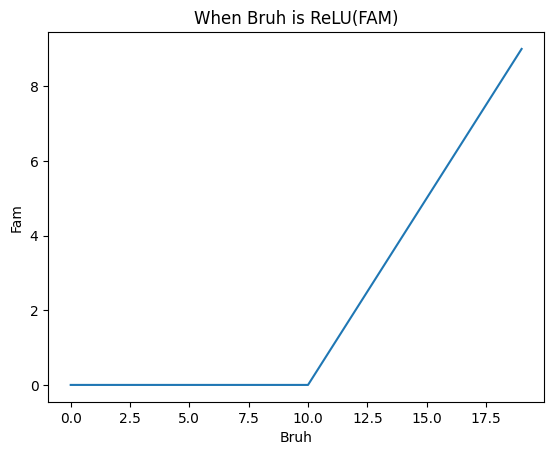

In [14]:
plt.plot(torch.relu(tensee))
plt.xlabel("Bruh")
plt.ylabel("Fam")
plt.title("When Bruh is ReLU(FAM)")
plt.show()

Another non-linear activation function, the sigmoid activation function. With this function.

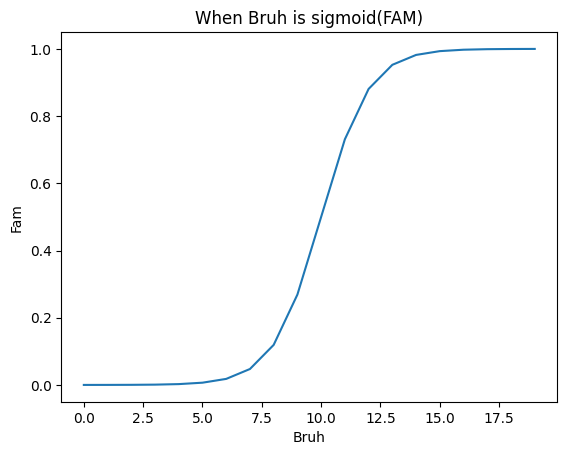

In [15]:
plt.plot(torch.sigmoid(tensee))
plt.xlabel("Bruh")
plt.ylabel("Fam")
plt.title("When Bruh is sigmoid(FAM)")
plt.show()

Now that we've practiced binary classification with points its time to upgrade our game. We're onto multiclass classification with multiple clusters of points. For this problem we will be getting a series of "blobs" and our goal is to do stuff and things to ultimately classify each of these blobs as their own clusters. First and foremost, I want to visualize whats going on here, with visuals I'll be able to get to a better point to decide where to go.

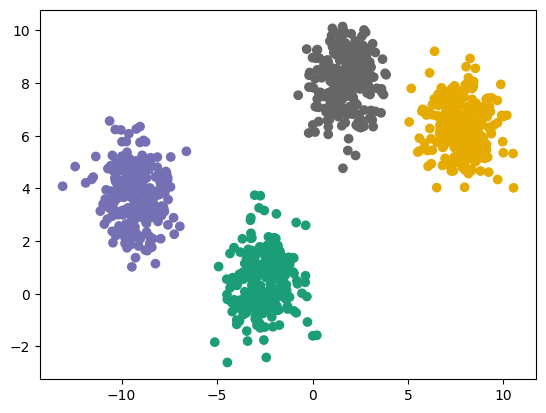

In [16]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

x, y = make_blobs(n_samples,
                  random_state=20,
                  n_features= 2,
                  centers = 4)

plt.scatter (x = x[:, 0],
              y = x[:, 1],
              c = y,
              cmap = plt.cm.Dark2_r);

Creating a pandas df helps with understanding what values we're dealing with to get a better idea of how to troubleshoot or to decide where to go from that point.

In [17]:
clusters = pd.DataFrame({"X1": x[:, 0],
                        "X2": x[:, 1],
                        "label": y})
clusters.head()

,X1,X2,label
0,1.355758,6.723061,0
1,-8.889937,4.983185,2
2,0.741033,8.426553,0
3,8.065031,5.421002,1
4,-8.272429,3.068777,2


Ok, now that we have everything it's time to split up the data and go from there. I'm going to use a function from scikit as it allows us to create a training and testing split in a streamlined and randomized manner. Afterwards, I'm going to use my device agnostic code to send this to a either CPU or GPU, depending on the circumstances.

In [18]:
# Conversion to torch float, we will be changing it from numpy.float64 to torch.float32
# Its good practice to convert to float32 as there may be some errors that arise from
# lack of use.
x = torch.from_numpy(x).type(torch.float32)
y = torch.from_numpy(y).type(torch.LongTensor)

# SplitLoc
X_train, X_test, Y_train, Y_test = train_test_split(x, y,
                                                    test_size = .2,
                                                    random_state = 42)

# Moving to devices an shi
X_train, X_test = X_train.to(device), X_test.to(device)
Y_train, Y_test = Y_train.to(device), Y_test.to(device)

Next, I'm going to create a model. Where I will again, use device agnostic code to send the model to either the GPU or the CPU, depending on the conditions and environment this code is running in.

There's so much beauty in code, I love doing this. It feels right.

Okay, now that we're going deeper, we're starting to see inputs for the models. These inputs are seen in the `__init__` section of the mdoel instantiation.

In [19]:
class blobson (nn.Module):
  def __init__(self, input, output, hidden = 8):
    super().__init__()
    self.doubleLayer = nn.Sequential(
        nn.Linear(in_features = input, out_features = hidden),
        nn.ReLU(),
        nn.Linear(in_features = hidden, out_features = hidden),
        nn.ReLU(),
        nn.Linear(in_features = hidden, out_features = hidden),
        nn.ReLU(),
        nn.Linear(in_features = hidden, out_features = hidden),
        nn.ReLU(),
        nn.Linear(in_features = hidden, out_features = output),
        )
  def forward(self, x):
    return self.doubleLayer(x)

# Initializing the model and sending it to the GPU (if we have one)
blob = blobson(input = 2,
               output = 4).to(device)

blob

blobson(
  (doubleLayer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=4, bias=True)
  )
)

Now that we have all the good good, its time to set up the loss function and optimizer. We will busing SGD for our optimizer and for our loss function we will be doing

In [20]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = blob.parameters(), lr = .1)

Here, we are going to look at outputs

In [21]:
blob(X_train)

tensor([[-0.1635, -0.2105, -0.3747,  0.0525],
        [-0.1894, -0.3147, -0.2224,  0.1453],
        [-0.1956, -0.3076, -0.2054,  0.1678],
        ...,
        [-0.1634, -0.1953, -0.4075,  0.0153],
        [-0.1884, -0.3032, -0.2180,  0.1642],
        [-0.1635, -0.2073, -0.3818,  0.0445]], grad_fn=<AddmmBackward0>)

Now for the training loop!!

In [22]:
# Establishing lists
epochCount = []
trainLosses = []
testLosses = []

# Establishing iteration count
epochs = 10000

# Training loop
for epoch in range(epochs):
  # Set to training
  blob.train()

  # train then model and capture predictions
  yTrainLogits = blob(X_train)
  yPred = torch.softmax(yTrainLogits, dim = 1).argmax(dim = 1)


  # Juxtapose in a loss_fn
  trainLoss = loss_fn(yTrainLogits, Y_train)

  # Do optimizer stuff and things, LEARN THIS ASAP
  optimizer.zero_grad()

  # Backpropogation for loss function
  trainLoss.backward()

  # Step the optimizer
  optimizer.step()

  blob.eval()
  with torch.inference_mode():
    # Forward
    yTestLogits = blob(X_test)
    yTestPred = torch.softmax(yTestLogits, dim = 1).argmax(dim = 1)

    # Juxtapose in loss
    testLoss = loss_fn(yTestLogits, Y_test)

  if epoch % 1000 == 0:
    # Print available data
    print(f"Epoch: {epoch} | Train loss: {trainLoss:.3f} | Test loss: {testLoss:.3f}")
  epochCount, trainLosses, testLosses = epochCount + [epoch], trainLosses + [trainLoss], testLosses + [testLoss]


Epoch: 0 | Train loss: 1.419 | Test loss: 1.421
Epoch: 1000 | Train loss: 0.016 | Test loss: 0.016
Epoch: 2000 | Train loss: 0.004 | Test loss: 0.005
Epoch: 3000 | Train loss: 0.002 | Test loss: 0.003
Epoch: 4000 | Train loss: 0.001 | Test loss: 0.002
Epoch: 5000 | Train loss: 0.001 | Test loss: 0.001
Epoch: 6000 | Train loss: 0.000 | Test loss: 0.001
Epoch: 7000 | Train loss: 0.000 | Test loss: 0.001
Epoch: 8000 | Train loss: 0.000 | Test loss: 0.001
Epoch: 9000 | Train loss: 0.000 | Test loss: 0.001


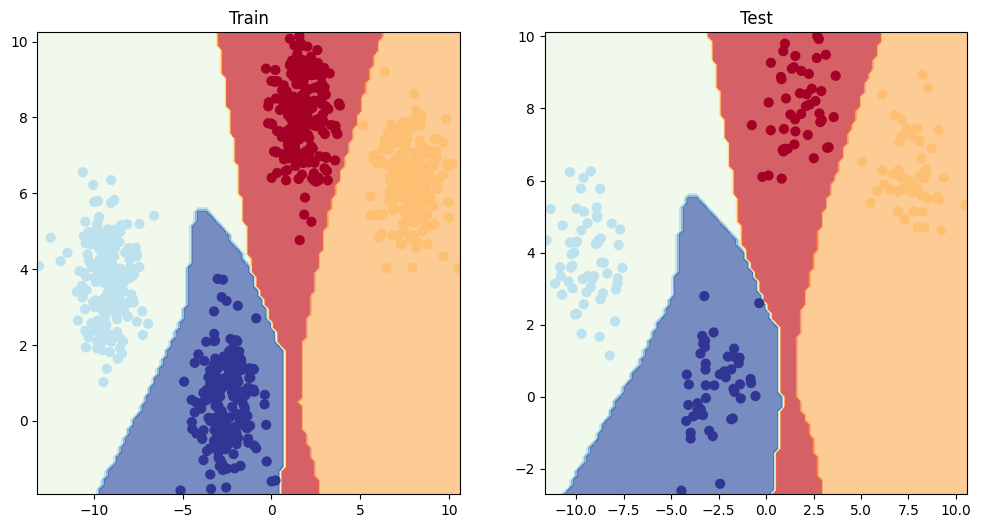

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot (1, 2, 1)
plt.title( "Train")
plot_decision_boundary(blob, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test" )
plot_decision_boundary(blob, X_test, Y_test)

Practice: Make Moons:

In [24]:
x, y = sklearn.datasets.make_moons(n_samples=1000, random_state = 42,
                                   noise = .1)
x = torch.from_numpy(x).type(torch.float32)
y = torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, Y_train, Y_test = train_test_split(x,y,
                                                    test_size = .2,
                                                    random_state = 42)

X_train, X_test = X_train.to(device), X_test.to(device)
Y_train, Y_test = Y_train.to(device), Y_test.to(device)

Plot:

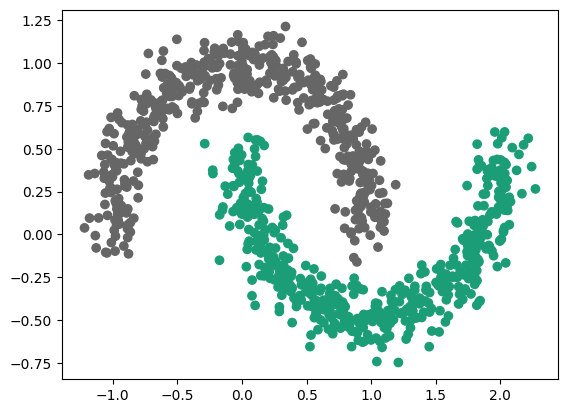

In [25]:
plt.scatter (x = x[:, 0],
              y = x[:, 1],
              c = y,
              cmap = plt.cm.Dark2_r);

Time to make the neural network.

In [26]:
class moonson (nn.Module):
  def __init__(self, input, output, hidden = 10):
    super().__init__()
    self.layerOverlord = nn.Sequential(
        nn.Linear(in_features = input, out_features = hidden),
        nn.Sigmoid(),
        nn.Linear(in_features = hidden, out_features = hidden),
        nn.Sigmoid(),
        nn.Linear(in_features = hidden, out_features = hidden),
        nn.Sigmoid(),
        nn.Linear(in_features = hidden, out_features = hidden),
        nn.Sigmoid(),
        nn.Linear(in_features = hidden, out_features = output),
        )
  def forward(self, x):
    return self.layerOverlord(x)

moon = moonson(input = 2, output = 2).to(device)
moon

moonson(
  (layerOverlord): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=10, out_features=2, bias=True)
  )
)

Optomizer and loss function:

In [27]:
optimizer = torch.optim.SGD(params = moon.parameters(), lr = .1)

loss_fn = nn.CrossEntropyLoss()

Training loop:

In [30]:
epochCount = []
losses = []
testLosses = []

epochs = 10000

for epoch in range(epochs):
  moon.train()

  # Setting up logits
  yTrainLogits = moon(X_train)

  # Setting upp predictive values
  yPred = torch.softmax(yTrainLogits, dim = 1).argmax(dim = 1)

  # Juxtapose in a loss_fn
  trainLoss = loss_fn(yTrainLogits, Y_train)

  # Do optimizer stuff and things, LEARN THIS ASAP
  optimizer.zero_grad()

  # Backpropogation for loss function
  trainLoss.backward()

  # Step the optimizer
  optimizer.step()

  moon.eval()
  with torch.inference_mode():
    # Forward
    yTestLogits = moon(X_test)
    yTestPred = torch.softmax(yTestLogits, dim = 1).argmax(dim = 1)

    # Juxtapose in loss
    testLoss = loss_fn(yTestLogits, Y_test)

  if epoch % 1000 == 0:
    # Print available data
    print(f"Epoch: {epoch} | Train loss: {trainLoss:.3f} | Test loss: {testLoss:.3f}")

Epoch: 0 | Train loss: 0.370 | Test loss: 0.388
Epoch: 1000 | Train loss: 0.265 | Test loss: 0.257
Epoch: 2000 | Train loss: 0.262 | Test loss: 0.254
Epoch: 3000 | Train loss: 0.260 | Test loss: 0.252
Epoch: 4000 | Train loss: 0.258 | Test loss: 0.250
Epoch: 5000 | Train loss: 0.249 | Test loss: 0.240
Epoch: 6000 | Train loss: 0.108 | Test loss: 0.095
Epoch: 7000 | Train loss: 0.021 | Test loss: 0.016
Epoch: 8000 | Train loss: 0.011 | Test loss: 0.007
Epoch: 9000 | Train loss: 0.008 | Test loss: 0.004


In [41]:
yTestLogits = moon(X_test)
yTestPred = torch.softmax(yTestLogits, dim = 1).argmax(dim = 1)
sum(Y_test == yTestPred)/len(Y_test)

tensor(1.)

I was unable to get the function to map properly, but its working!! 100% of the test values are matching with our predicted test values. We so back baby!!
